In [94]:
import numpy as np
import pandas as pd
import src.online_learning.adaptation_utils.adaptation_due as adaptation
from src.online_learning.cluster import Cluster
import notebooks.online_learning.utils.plotting_utils as plot
import notebooks.online_learning.utils.loading_utils as load
import seaborn as sns
from scipy import stats
from scipy.stats import norm, lognorm, expon
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import chi2

In [33]:
nominal_cluster_file_path = "data/rse/phi_one.csv"
theta_history_file_path = "data/artificial/theta_history.csv"

## Adaptation Routine

In order to test the adaptation routine consider the following setting:

1. A nominal cluster from rse experiment
2. thetas of the optimizer are artificial generated

The aim is to show how a nominal cluster evolve in the time(aging) and when there is an abrupt changing

In [10]:
phi_one_df = load.csv_as_df( nominal_cluster_file_path)

In [11]:
phi_one_df.describe()

,Temp,Soc,C_1,R_0,R_1
count,60.000000,60.000000,60.000000,60.000000,60.000000
mean,19.000000,25.000000,9338.054441,0.016977,0.029842
std,6.689227,17.222374,4119.364769,0.006542,0.031361
min,10.000000,0.000000,103.544660,0.010700,0.011082
25%,10.000000,10.000000,7019.698113,0.011697,0.014969
50%,22.500000,25.000000,10630.167240,0.015171,0.019005
75%,25.000000,40.000000,11866.580522,0.020059,0.028063
max,25.000000,50.000000,15492.034923,0.043449,0.153520


In [12]:
phi_one_df.head()

,Temp,Soc,C_1,R_0,R_1
0,15,0,9362.838793,0.016177,0.016432
1,15,10,9691.182929,0.016623,0.019499
2,15,20,12052.351794,0.017420,0.023310
3,15,30,9306.629723,0.018662,0.024055
4,15,40,5139.236488,0.024588,0.035098


Preprocessing:

In [19]:
phi_one_df = phi_one_df.drop(['Temp','Soc'],axis=1)

In [20]:
new_column_names = {
    'R_0': 'r0',
    'R_1': 'rc',
    'C_1': 'c'
}
phi_one_df = phi_one_df.rename(columns=new_column_names)

In [21]:
phi_one_df.describe()

,c,r0,rc
count,60.000000,60.000000,60.000000
mean,9338.054441,0.016977,0.029842
std,4119.364769,0.006542,0.031361
min,103.544660,0.010700,0.011082
25%,7019.698113,0.011697,0.014969
50%,10630.167240,0.015171,0.019005
75%,11866.580522,0.020059,0.028063
max,15492.034923,0.043449,0.153520


## Temp: 10-25 and SoC:0-0.5

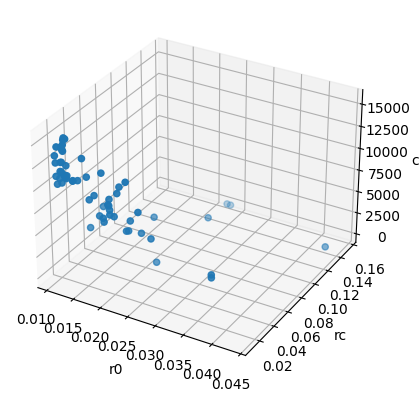

In [22]:
plot.threed_scatter(phi_one_df)

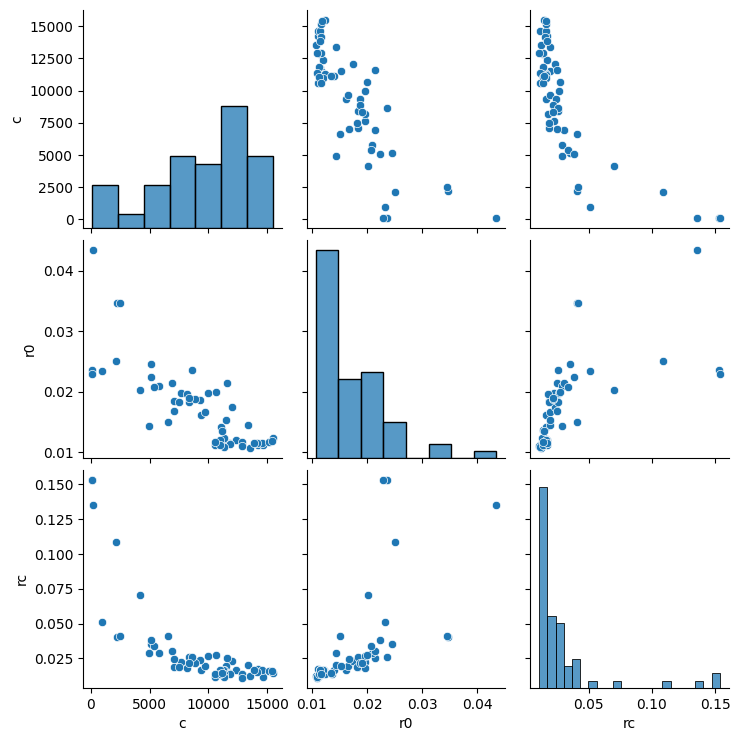

In [24]:
plot.pairwise_scatter(phi_one_df)

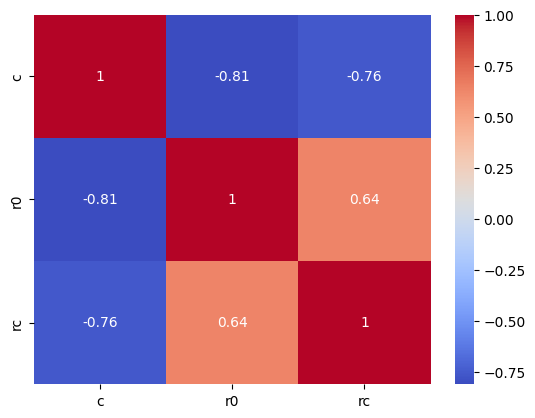

In [25]:
plot.correlation_heatmap(phi_one_df)

Check if the underlinyning distribution is a gaussian

In [95]:
plot.qq_plots(phi_one_df)

AttributeError: module 'notebooks.online_learning.utils.plotting_utils' has no attribute 'qq_plots'

In [92]:
# Shapiro-Wilk test for each variable: Univariate Normality test
for column in phi_one_df.columns:
    stat, p_value = stats.shapiro(phi_one_df[column])
    print(f'{column}: Shapiro-Wilk test stat={stat}, p-value={p_value}')

c: Shapiro-Wilk test stat=0.9358622431755066, p-value=0.003552642185240984
r0: Shapiro-Wilk test stat=0.814231812953949, p-value=3.111978230663226e-07
rc: Shapiro-Wilk test stat=0.5388643145561218, p-value=1.9075199319401603e-12


In [96]:
# Mardia's test for multivariate normality
mardia_test = pg.multivariate_normality(phi_one_df, alpha=0.05)
print(mardia_test)

HZResults(hz=4.881835202952099, pval=4.957098004245731e-21, normal=False)


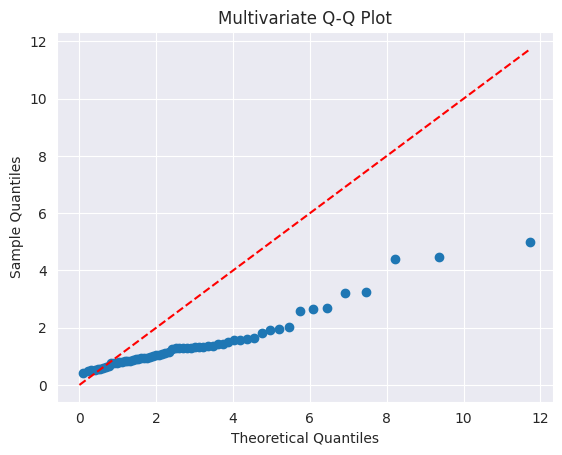

In [98]:
# Calculate the covariance matrix and its inverse
cov_matrix = np.cov(phi_one_df, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mean_values = np.mean(phi_one_df.values, axis=0)

# Calculate Mahalanobis distances for each observation
mahalanobis_distances = []
for i in range(len(phi_one_df)):
    diff = phi_one_df.iloc[i] - mean_values
    md = np.sqrt(diff.T @ inv_cov_matrix @ diff)
    mahalanobis_distances.append(md)

# Sort Mahalanobis distances and theoretical chi-squared quantiles
sorted_md = np.sort(mahalanobis_distances)
chi_squared_values = chi2.ppf((np.arange(1, len(phi_one_df) + 1) - 0.5) / len(phi_one_df), df=3)

# Q-Q plot for Mahalanobis distances
plt.scatter(chi_squared_values, sorted_md)
plt.plot([0, max(chi_squared_values)], [0, max(chi_squared_values)], color='red', linestyle='--')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Multivariate Q-Q Plot')
plt.show()

RMK: Artificial generated Stream of theta

In [39]:
theta_history_df = load.csv_as_df(theta_history_file_path)

In [40]:
theta_history_df.describe()

,r0,rc,c
count,670.000000,670.000000,670.000000
mean,0.585122,0.580691,4821.724350
std,0.933148,0.856845,4609.430259
min,-2.548609,-2.238882,4.684811
25%,0.083211,0.078967,3426.341519
50%,0.398652,0.434707,4610.194299
75%,1.060783,0.968224,4611.686300
max,4.622824,4.483110,37553.120777


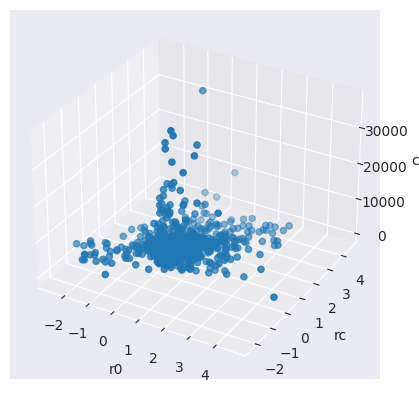

In [41]:
plot.threed_scatter(theta_history_df)

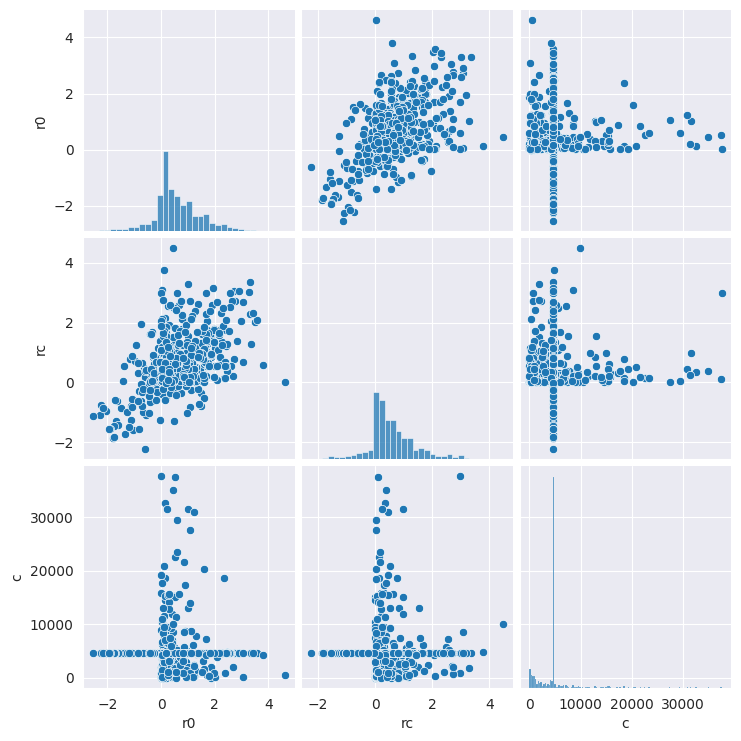

In [42]:
plot.pairwise_scatter(theta_history_df)

## build the cluster object

In [60]:
parameters = [phi_one_df.values[i] for i in range(phi_one_df.values.shape[0])]
phi_one = Cluster()
phi_one.set(parameters)
phi_one.compute_centroid()
phi_one.compute_covariance_matrix()

array([[ 1.69691661e+07, -2.18406559e+01, -9.77624409e+01],
       [-2.18406559e+01,  4.27948784e-05,  1.31134961e-04],
       [-9.77624409e+01,  1.31134961e-04,  9.83488949e-04]])

## flow of the adaptation routine

In [61]:
theta_history = theta_history_df.values

In [62]:
np.shape(theta_history)

(670, 3)

In [63]:
theta_history = [theta_history[i] for i in range(theta_history.shape[0]) ]

In [67]:
outliers = []
for k,theta in enumerate(theta_history):
    if phi_one.contains_within(theta) == True :
        pass
        #phi_one.add(theta)
        #phi_one.compute_centroid()
        #print("centroid:", phi_one.get_centroid())
        #phi_one.compute_covariance_matrix()
    else:
        outliers.append(theta)
        phi_hat = adaptation.fault_cluster_creation(cluster_points= phi_one_df.values,
                                                    outliers=np.vstack(outliers))   

ks_value 0.6666666666666666 p_value 0.07928689370587744
Fail to reject the null hypothesis: f_hat and f_tau are the same. No new cluster needed.
ks_value 0.6666666666666666 p_value 0.004898000675818735
Reject the null hypothesis: f_hat and f_tau are different. Create a new cluster.
[[4.58921969e-01 6.84906414e-01 4.61049051e+03]
 [2.75414703e+00 2.73236735e+00 4.61326065e+03]]
len di O_tilde: 1
len of O 1
dont want this !!!
ks_value 0.5555555555555556 p_value 0.005489706722422446
Reject the null hypothesis: f_hat and f_tau are different. Create a new cluster.
[[-3.97850788e-02  5.72085579e-01  4.60991880e+03]
 [ 2.75414703e+00  2.73236735e+00  4.61326065e+03]
 [-3.97850788e-02  5.72085579e-01  4.60991880e+03]]
len di O_tilde: 2
len of O 2
dont want this !!!
ks_value 0.5833333333333334 p_value 0.00040669882519383914
Reject the null hypothesis: f_hat and f_tau are different. Create a new cluster.
[[-3.97850788e-02  2.91010314e-01  4.60991880e+03]
 [-3.97850788e-02  2.91010314e-01  4.6099

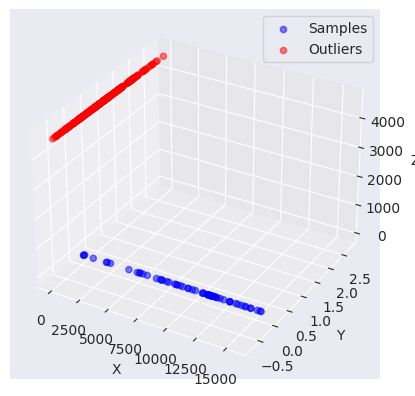

In [69]:
plot.samples_and_outliers(samples=phi_one_df.values,
                          outliers=np.vstack(phi_hat.get_parameters()))

In [74]:
phi_hat_df = pd.DataFrame(np.vstack(phi_hat.get_parameters()), columns= ['r0','rc','c'])

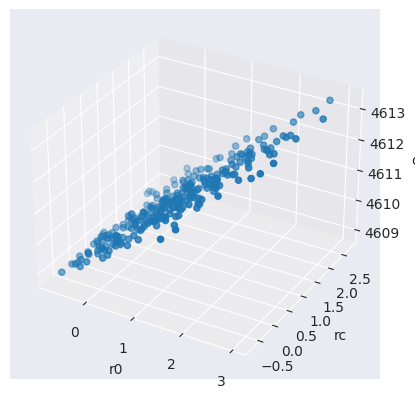

In [75]:
plot.threed_scatter(phi_hat_df)

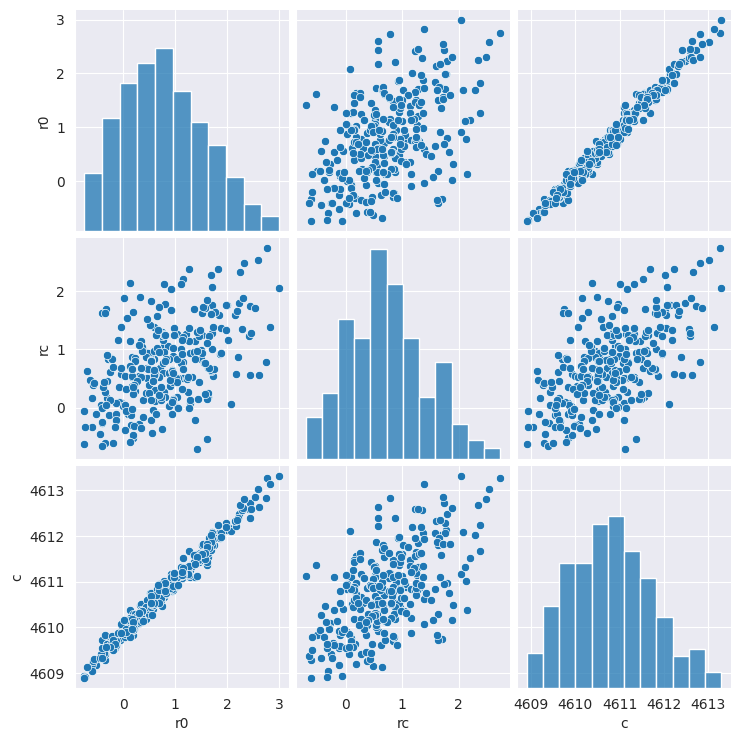

In [76]:
plot.pairwise_scatter(phi_hat_df)

In [81]:
phi_one_df.describe()

,c,r0,rc
count,60.000000,60.000000,60.000000
mean,9338.054441,0.016977,0.029842
std,4119.364769,0.006542,0.031361
min,103.544660,0.010700,0.011082
25%,7019.698113,0.011697,0.014969
50%,10630.167240,0.015171,0.019005
75%,11866.580522,0.020059,0.028063
max,15492.034923,0.043449,0.153520


In [82]:
phi_hat_df.describe()

,r0,rc,c
count,283.000000,283.000000,283.000000
mean,0.797508,0.736718,4610.804883
std,0.806161,0.699820,0.925329
min,-0.746845,-0.711502,4608.903329
25%,0.177497,0.199868,4610.131226
50%,0.741013,0.676350,4610.796109
75%,1.378238,1.225689,4611.428139
max,2.994096,2.732367,4613.298117
